# Comprehensive Scenario Sampling & Advanced Stratified Evaluation

This notebook performs **full enumeration** for 1–2 criterion combinations and **binning + stratified sampling** for 3–5 criterion combinations, with extensive logging, print statements, and enhanced visualizations:

- **Verbose Logging & Prints:** DEBUG‑level logs and key print outputs at each major step.  
- **Additional Plots:** CDF, boxplots, KDE overlays, and bin distributions.

**Sections**  
1. Imports & Configuration  
2. Utility Functions  
3. Criteria Pool & Column Mapping  
4. Load Raw Data  
5. Scenario Generation & Frequency Counting  
6. Full Enumeration for 1–2 Criteria  
7. Binning & Sampling for 3–5 Criteria  
8. Save Results


In [ ]:
# 1. Imports & Configuration
import os
import random
import logging
from itertools import combinations, product
from typing import Any, List, Tuple, Dict, Set

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# Configuration
INPUT_CSV = "/content/drive/MyDrive/dataFullLargerRegionAndCountryWithServingsBin.csv"
OUTPUT_DIR = "/content/scenario_detailed_v3"
os.makedirs(OUTPUT_DIR, exist_ok=True)

FULL_SIZES   = [1, 2]
SAMPLE_SIZES = [3, 4, 5]

# Binning strategy: 'sturges', 'doane' or 'fd' (Freedman–Diaconis)
BINNING_METHOD = 'fd'

sample_frac = 0.5      # fraction to sample within each bin
RANDOM_SEED = 42

# Logging setup
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s [%(levelname)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
root = logging.getLogger()
root.setLevel(logging.DEBUG)
for handler in root.handlers:
    handler.setLevel(logging.DEBUG)

# Plot style
sns.set_theme(style='whitegrid')

# ——— Dynamic bin count calculation function ———
def get_bin_count(arr: np.ndarray,
                  method: str = BINNING_METHOD,
                  min_bin_size_ratio: float = 0.05) -> int:
    """
    Calculate the number of bins for a histogram.

    - If method == 'sturges' or 'doane', use the classic formulas.
    - If method == 'fd' (Freedman–Diaconis), compute the FD bin width,
      then decrease the bin count until each bin has at least
      min_bin_size_ratio * n samples.
    """
    n = len(arr)

    # 1) Sturges' rule
    if method == 'sturges':
        return int(np.ceil(np.log2(n) + 1))

    # 2) Doane's formula
    elif method == 'doane':
        m2 = ((arr - arr.mean())**2).mean()
        m3 = ((arr - arr.mean())**3).mean()
        g1 = m3 / (m2**1.5) if m2 > 0 else 0
        sigma_g1 = np.sqrt(6 * (n - 2) / ((n + 1) * (n + 3)))
        return int(np.ceil(1 + np.log2(n) + np.log2(1 + abs(g1) / sigma_g1)))

    # 3) Freedman–Diaconis with minimum bin population check
    data = pd.Series(arr).dropna()
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    fd_width = 2 * iqr * (n ** (-1/3))

    # Fallback if IQR is zero or very small
    if fd_width <= 0:
        return max(1, int(np.sqrt(n)))

    initial_bins = int(np.ceil((data.max() - data.min()) / fd_width))
    min_samples = max(1, int(n * min_bin_size_ratio))

    for bins in range(initial_bins, 0, -1):
        try:
            binned = pd.qcut(data, q=bins, duplicates='drop')
            if binned.value_counts().min() >= min_samples:
                return bins
        except ValueError:
            # Too many bins for the data; skip
            continue

    # If all else fails
    return 1

print(f"[CONFIG] Input CSV: {INPUT_CSV}")
print(f"[CONFIG] Output directory: {OUTPUT_DIR}")
print(f"[CONFIG] Full enumeration sizes: {FULL_SIZES}")
print(f"[CONFIG] Sample sizes: {SAMPLE_SIZES}")
print(f"[CONFIG] Binning method: {BINNING_METHOD}")


[CONFIG] Input CSV: /content/drive/MyDrive/dataFullLargerRegionAndCountryWithServingsBin.csv
[CONFIG] Output directory: /content/scenario_detailed_v3
[CONFIG] Full enumeration sizes: [1, 2]
[CONFIG] Sample sizes: [3, 4, 5]
[CONFIG] Binning method: fd


### 2. Utility Functions  
Define cleaning functions with print diagnostics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Utility functions for cleaning

def strip_label(x: Any) -> str:
    if pd.isna(x):
        return ""
    return str(x).strip()


def split_and_strip(x: Any, sep: str = ',') -> List[str]:
    if pd.isna(x):
        return []
    parts = [item.strip() for item in str(x).split(sep) if item.strip()]
    if not parts:
        print(f"[WARNING] split_and_strip found no parts in: {x}")
    return parts


### 3. Criteria Pool & Column Mapping  
Set up static definitions and print mapping details.

In [ ]:
# Criteria options
define = {
    "HasProteinLevel": ["Low Protein", "Medium Protein", "High Protein"],
    "HasCarbLevel":    ["Low Carb", "Medium Carb", "High Carb"],
    "HasFatLevel":     ["Low Fat", "Medium Fat", "High Fat"],
    "HasCalorieLevel": ["Low Calorie", "Medium Calorie", "High Calorie"],
    "isForMealType":   ["breakfast", "lunch", "dinner", "snack", "dessert", "starter", "brunch", "drink"],
    "hasDietType":     ["Vegetarian", "Vegan", "Paleo", "Standard"],
    "hasCuisineRegion":["North America", "Global", "Mediterranean Europe", "Northern/Western Europe", "Latin America",
                          "East Asia", "South Asia", "Southeast Asia", "Middle East & Anatolia",
                          "Oceania", "Eastern Europe & Eurasia", "Caribbean", "Sub-Saharan Africa"],
    "usesCookingMethod":["oven", "pot", "pan", "no cook", "barbecue", "air fryer", "microwave"],
}
available_options = {rel: vals.copy() for rel, vals in define.items()}

# Column mapping
def map_column(rel: str) -> Tuple[str, bool]:
    if rel.endswith("Level"): return "Healthy_Type", True
    if rel == "isForMealType": return "meal_type", True
    if rel == "hasDietType": return "Diet_Types", True
    if rel == "hasCuisineRegion": return "CuisineRegion", False
    return "Cooking_Method", True

col_map = {rel: map_column(rel) for rel in available_options}
print("[INFO] Available relations and their columns:")
for rel, (col, multi) in col_map.items():
    print(f" - {rel}: column='{col}', multi-valued={multi}")


[INFO] Available relations and their columns:
 - HasProteinLevel: column='Healthy_Type', multi-valued=True
 - HasCarbLevel: column='Healthy_Type', multi-valued=True
 - HasFatLevel: column='Healthy_Type', multi-valued=True
 - HasCalorieLevel: column='Healthy_Type', multi-valued=True
 - isForMealType: column='meal_type', multi-valued=True
 - hasDietType: column='Diet_Types', multi-valued=True
 - hasCuisineRegion: column='CuisineRegion', multi-valued=False
 - usesCookingMethod: column='Cooking_Method', multi-valued=True


### 4. Load Raw Data  
Load the data and print basic stats.

In [ ]:
print("[INFO] Loading raw data from CSV...")
df_raw = pd.read_csv(INPUT_CSV)
print(f"[DATA] Loaded {len(df_raw)} rows, {len(df_raw.columns)} columns")
print(f"[DATA] Columns: {list(df_raw.columns)}")


[INFO] Loading raw data from CSV...
[DATA] Loaded 88519 rows, 38 columns
[DATA] Columns: ['RecipeId', 'Name', 'Description', 'Images', 'RecipeCategory', 'Keywords', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeInstructions', 'cook_time', 'Healthy_Type', 'RecipeIngredientQuantities', 'RegionCountry', 'URL', 'occasion', 'meal_type', 'Diet_Types', 'ScrapedIngredients', 'RecipeIngredientParts', 'CleanedRegionCountry', 'CleanedRegion', 'Best_foodentityname', 'Best_foodentitylink', 'RegionPart', 'CountryPart', 'CuisineRegion', 'BestUsdaIngredientName', 'UsdaIngredientMappedId', 'Cooking_Method', 'servings_bin']


### 5. Scenario Generation & Frequency Counting  
Define and print counts during generation.

In [ ]:
# --- 2. Build inverted‐index once ---
print("[INFO] Building inverted index...")
index_map: Dict[Tuple[str,str], Set[int]] = {}

# Pre‐extract split columns to speed up
cached_lists: Dict[str, pd.Series] = {}
for rel, vals in available_options.items():
    col, multi = col_map[rel]
    if multi:
        cached_lists[rel] = df_raw[col].apply(lambda x: set(split_and_strip(x)))
    else:
        cached_lists[rel] = df_raw[col].apply(strip_label)

for rel, vals in available_options.items():
    multi = col_map[rel][1]
    col_cache = cached_lists[rel]
    for val in vals:
        if multi:
            idx = set(col_cache[col_cache.apply(lambda s: val in s)].index)
        else:
            idx = set(col_cache[col_cache == val].index)
        index_map[(rel, val)] = idx

[INFO] Building inverted index...


In [ ]:
# --- 3. Fast match counting via set‐intersection ---
def count_matches_fast(scenario: List[Tuple[str, str]]) -> int:
    # fetch all index‐sets, sort by size asc → intersect
    sets = [ index_map[(rel,val)] for rel,val in scenario ]
    if not sets:
        return 0
    intersected = reduce(set.intersection, sorted(sets, key=len))
    return len(intersected)

# --- 4. Scenario generator (unchanged) ---
def generate_scenarios(rel_opts: Dict[str, List[str]], size: int):
    items = [(r, rel_opts[r]) for r in rel_opts]
    combos = []
    for combo in combinations(items, size):
        rels, lists_ = zip(*combo)
        for vals in product(*lists_):
            combos.append(list(zip(rels, vals)))
    print(f"[DEBUG] {size}-size: {len(combos)} combos")
    return combos

### 6. Full Enumeration for 1–2 Criteria  
Include prints around plots.


=== Full enumeration for size=1 ===
[DEBUG] 1-size: 44 combos


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(

[INFO] 44/44 scenarios have >0 matches
[STATS] match_count stats: {'count': 44.0, 'mean': 17298.727272727272, 'std': 16383.86384471104, 'min': 45.0, '25%': 3761.75, '50%': 9540.5, '75%': 31223.0, 'max': 55182.0}


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(

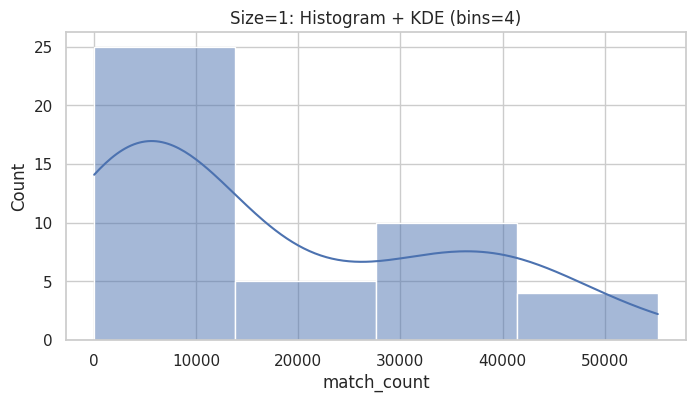

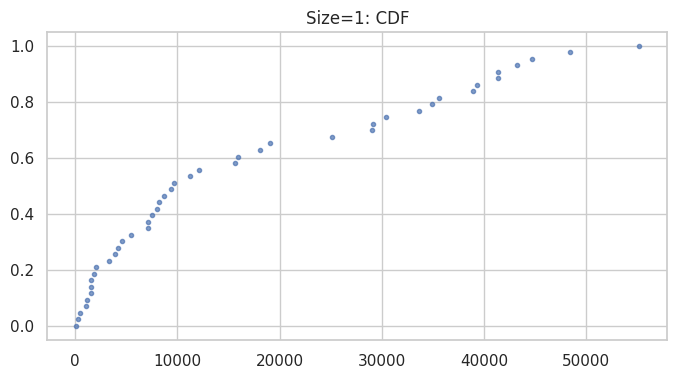

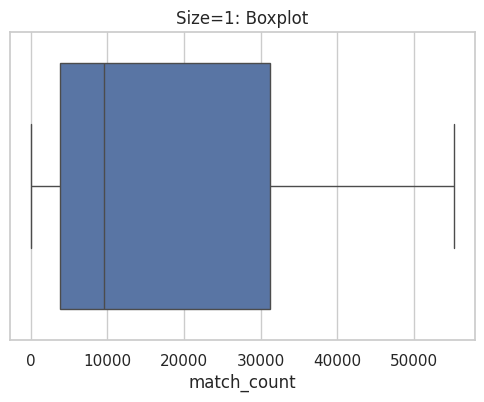

[SAVED] Full scenarios size=1 -> /content/scenario_detailed_v3/full_scenarios_size_1.csv

=== Full enumeration for size=2 ===
[DEBUG] 2-size: 801 combos
[INFO] 793/801 scenarios have >0 matches
[STATS] match_count stats: {'count': 793.0, 'mean': 3601.6065573770493, 'std': 5824.690496095949, 'min': 1.0, '25%': 236.0, '50%': 1022.0, '75%': 3995.0, 'max': 32005.0}


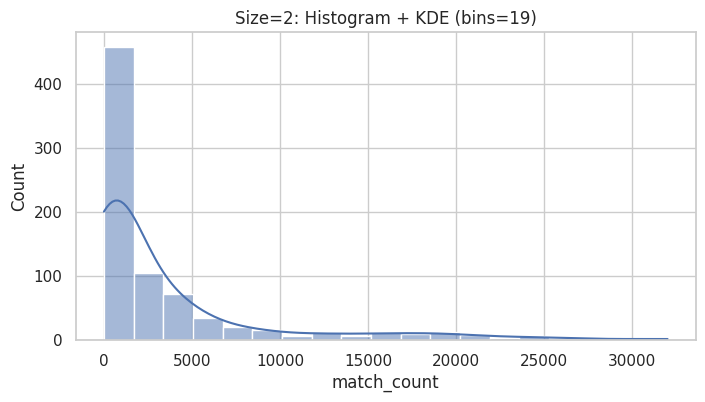

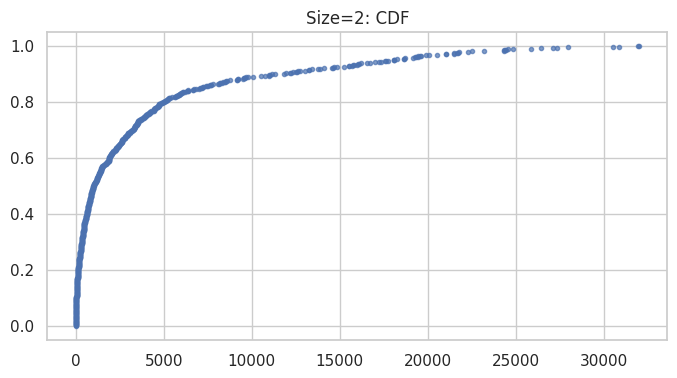

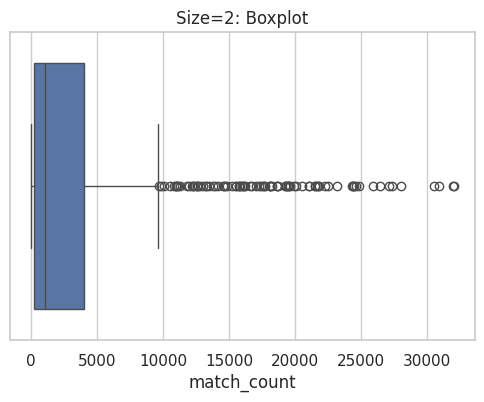

[SAVED] Full scenarios size=2 -> /content/scenario_detailed_v3/full_scenarios_size_2.csv


In [ ]:
from multiprocessing import Pool, cpu_count

for size in FULL_SIZES:
    print(f"\n=== Full enumeration for size={size} ===")
    scenarios = generate_scenarios(available_options, size)

    # parallelize count_matches_fast across available cores
    with Pool(max(1, cpu_count() - 1)) as pool:
        counts = pool.map(count_matches_fast, scenarios)

    # collect results into DataFrame and filter out zero‐match scenarios
    df_full = pd.DataFrame({
        'scenario':    scenarios,
        'match_count': counts
    })
    df_full = df_full[df_full['match_count'] > 0]
    print(f"[INFO] {len(df_full)}/{len(scenarios)} scenarios have >0 matches")

    # Summary statistics
    print("[STATS] match_count stats:", df_full['match_count'].describe().to_dict())

    # compute dynamic number of bins for histogram
    num_bins = get_bin_count(df_full['match_count'].values)

    # Histogram + KDE
    plt.figure(figsize=(8,4))
    sns.histplot(df_full['match_count'], bins=num_bins, kde=True)
    plt.title(f"Size={size}: Histogram + KDE (bins={num_bins})")
    plt.show()

    # CDF plot
    sorted_c = np.sort(df_full['match_count'])
    cdf = np.arange(len(sorted_c)) / (len(sorted_c)-1)
    plt.figure(figsize=(8,4))
    plt.plot(sorted_c, cdf, '.', alpha=0.7)
    plt.title(f"Size={size}: CDF")
    plt.show()

    # Boxplot
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df_full['match_count'])
    plt.title(f"Size={size}: Boxplot")
    plt.show()

    # Save results to CSV
    path = os.path.join(OUTPUT_DIR, f"full_scenarios_size_{size}.csv")
    df_full.to_csv(path, index=False)
    print(f"[SAVED] Full scenarios size={size} -> {path}")


### 7. Binning & Sampling for 3–5 Criteria

> Blok alıntı ekle



> Blok alıntı ekle


Include prints for bin edges, sample counts, etc.


=== Binning & sampling for size=3 ===
[DEBUG] 3-size: 7924 combos
[INFO] 7342/7924 scenarios have >0 matches
[STATS] match_count describe: {'count': 7342.0, 'mean': 832.1061018795968, 'std': 2000.0967019376985, 'min': 1.0, '25%': 25.0, '50%': 140.0, '75%': 653.75, 'max': 24361.0}
[INFO] Using 17 bins for histogram (method=fd)


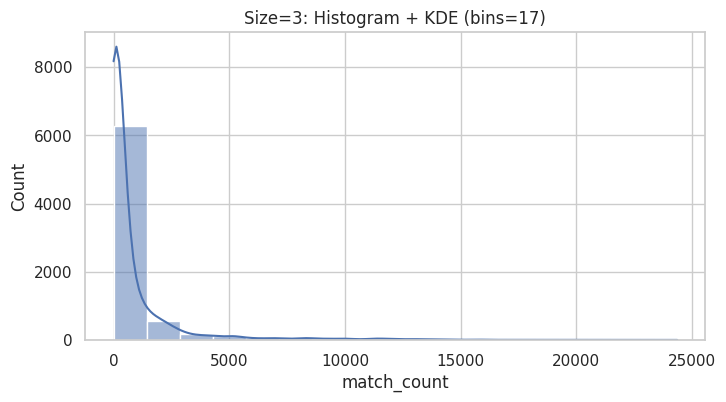

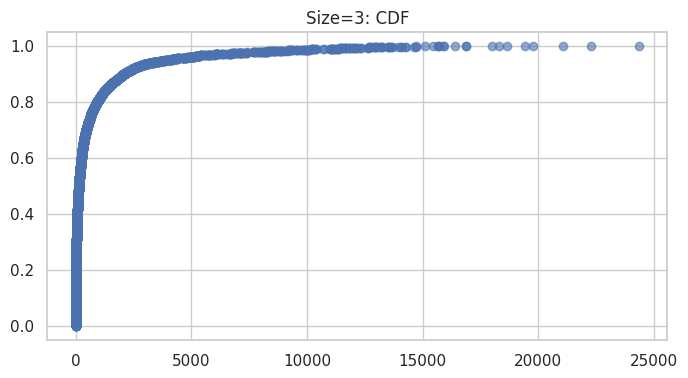

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[INFO] Bin edges: [1.00000e+00 3.00000e+00 7.00000e+00 1.40000e+01 2.20000e+01 3.50000e+01
 5.30000e+01 7.90000e+01 1.16590e+02 1.67000e+02 2.38000e+02 3.25060e+02
 4.79760e+02 7.09410e+02 1.11706e+03 1.83735e+03 3.38888e+03 2.43610e+04], using 17 quantile bins


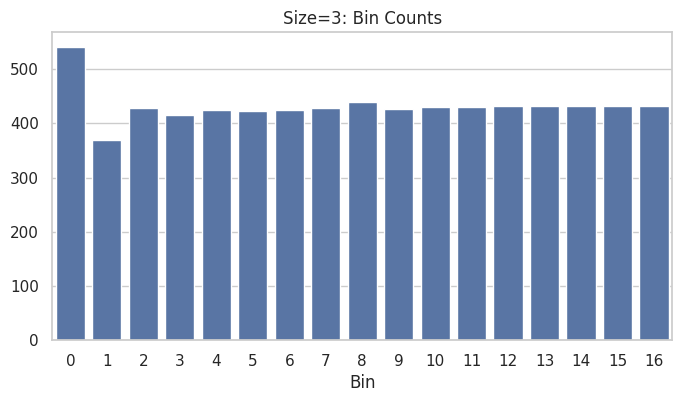

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


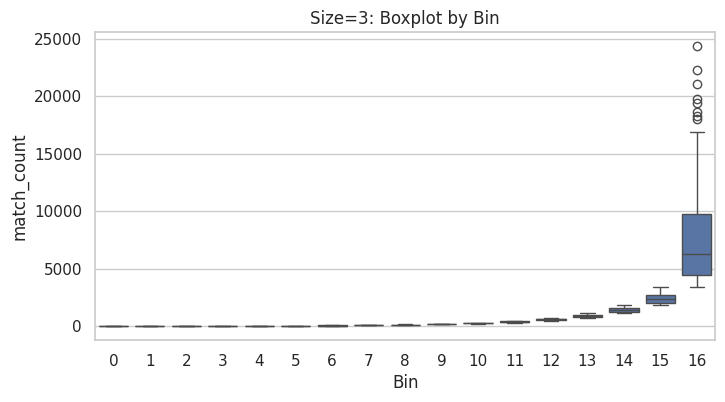

<ipython-input-9-7a92927b27be>:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(frac=sample_frac, random_state=RANDOM_SEED))
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[INFO] Sampled 3671 scenarios (frac=50%)
[INFO] Sample counts per bin: {0: 270, 1: 185, 2: 214, 3: 208, 4: 212, 5: 211, 6: 212, 7: 214, 8: 220, 9: 214, 10: 215, 11: 216, 12: 216, 13: 216, 14: 216, 15: 216, 16: 216}


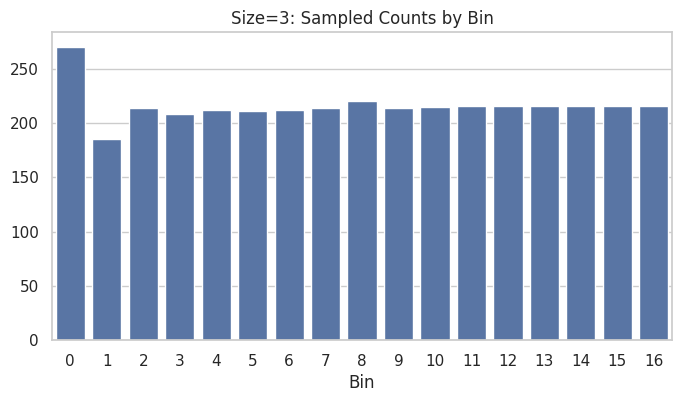

[SAVED] Binning results -> /content/scenario_detailed_v3/binning_full_size_3.csv
[SAVED] Sampled scenarios -> /content/scenario_detailed_v3/sampled_scenarios_size_3.csv

=== Binning & sampling for size=4 ===
[DEBUG] 4-size: 46835 combos
[INFO] 36182/46835 scenarios have >0 matches
[STATS] match_count describe: {'count': 36182.0, 'mean': 225.22842850035929, 'std': 731.4752672394291, 'min': 1.0, '25%': 6.0, '50%': 26.0, '75%': 130.0, 'max': 16129.0}
[INFO] Using 15 bins for histogram (method=fd)


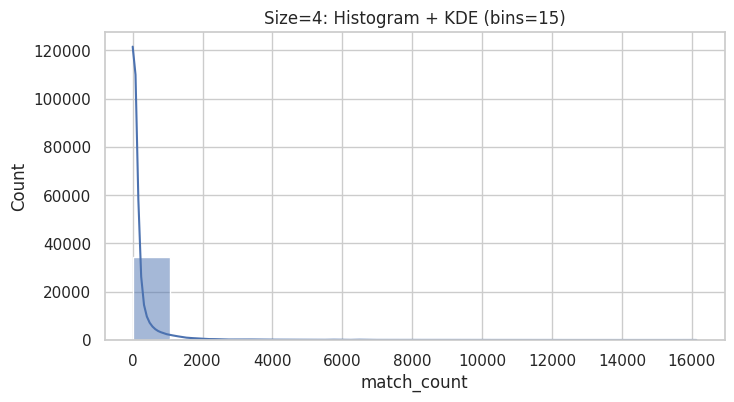

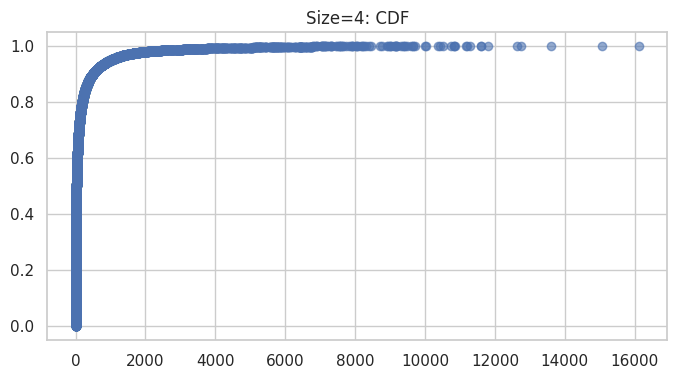

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[INFO] Bin edges: [1.0000e+00 2.0000e+00 4.0000e+00 6.0000e+00 1.0000e+01 1.4000e+01
 2.1000e+01 3.2000e+01 4.9000e+01 7.4000e+01 1.1500e+02 1.9200e+02
 3.4700e+02 7.8600e+02 1.6129e+04], using 15 quantile bins


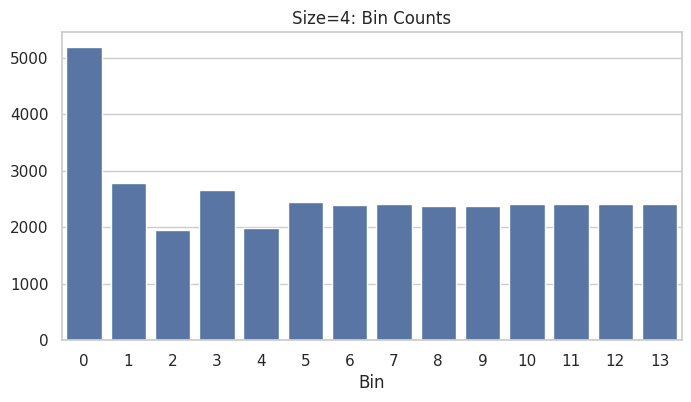

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


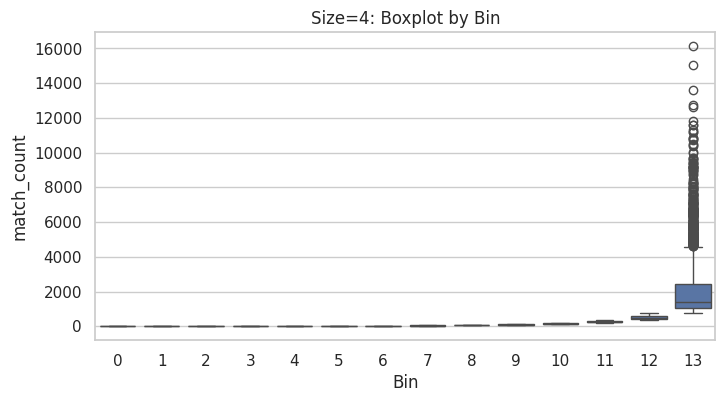

<ipython-input-9-7a92927b27be>:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(frac=sample_frac, random_state=RANDOM_SEED))
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[INFO] Sampled 18091 scenarios (frac=50%)
[INFO] Sample counts per bin: {0: 2594, 1: 1391, 2: 976, 3: 1324, 4: 990, 5: 1218, 6: 1200, 7: 1201, 8: 1188, 9: 1188, 10: 1204, 11: 1209, 12: 1202, 13: 1206}


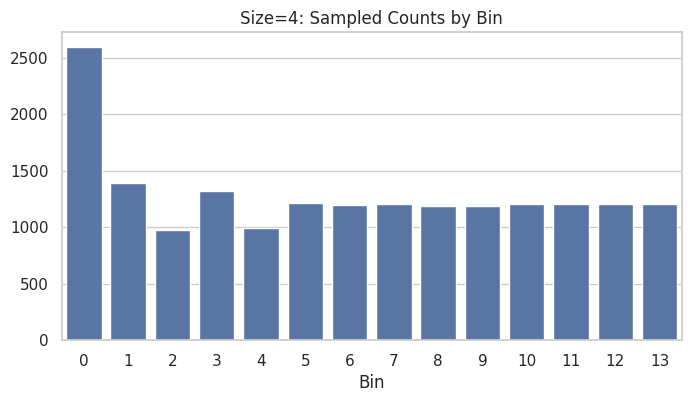

[SAVED] Binning results -> /content/scenario_detailed_v3/binning_full_size_4.csv
[SAVED] Sampled scenarios -> /content/scenario_detailed_v3/sampled_scenarios_size_4.csv

=== Binning & sampling for size=5 ===
[DEBUG] 5-size: 170268 combos
[INFO] 93234/170268 scenarios have >0 matches
[STATS] match_count describe: {'count': 93234.0, 'mean': 74.45925306218761, 'std': 296.79659351815513, 'min': 1.0, '25%': 2.0, '50%': 8.0, '75%': 37.0, 'max': 10367.0}
[INFO] Using 16 bins for histogram (method=fd)


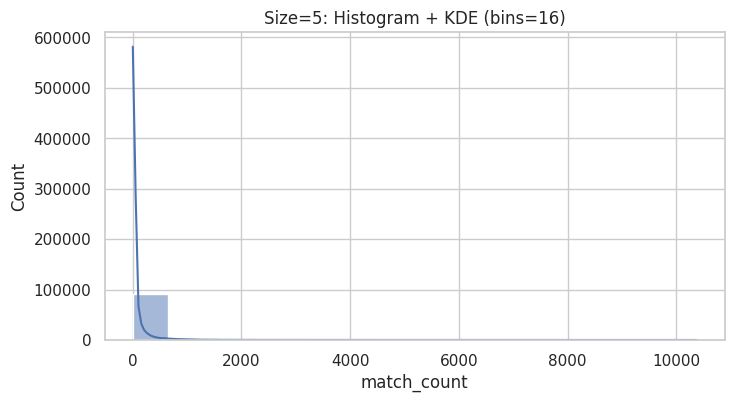

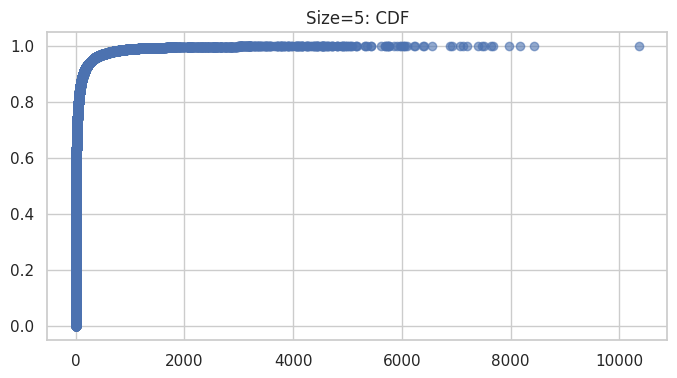

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[INFO] Bin edges: [1.0000e+00 2.0000e+00 3.0000e+00 4.0000e+00 6.0000e+00 8.0000e+00
 1.2000e+01 1.7000e+01 2.5000e+01 3.7000e+01 6.0000e+01 1.0800e+02
 2.4700e+02 1.0367e+04], using 16 quantile bins


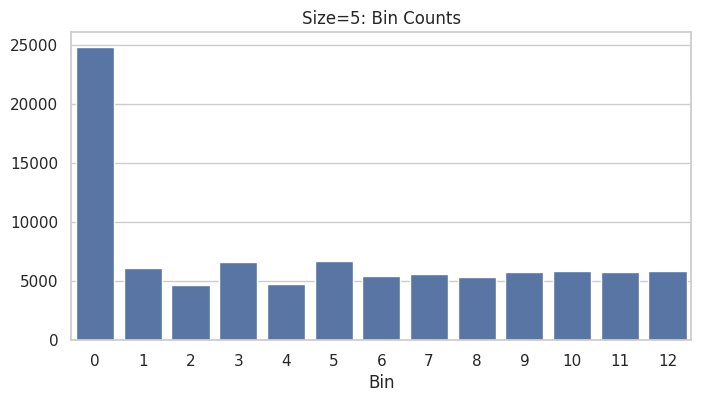

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


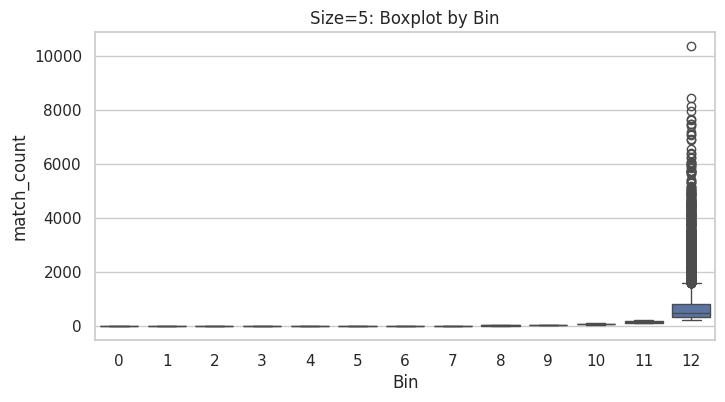

<ipython-input-9-7a92927b27be>:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(frac=sample_frac, random_state=RANDOM_SEED))
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[INFO] Sampled 46616 scenarios (frac=50%)
[INFO] Sample counts per bin: {0: 12403, 1: 3050, 2: 2347, 3: 3290, 4: 2364, 5: 3340, 6: 2727, 7: 2817, 8: 2658, 9: 2892, 10: 2926, 11: 2891, 12: 2911}


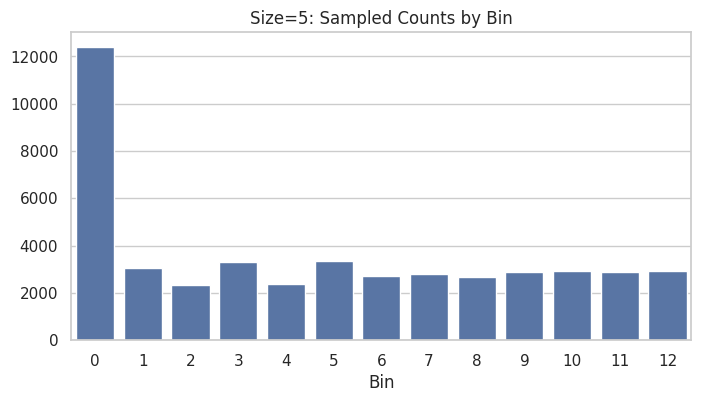

[SAVED] Binning results -> /content/scenario_detailed_v3/binning_full_size_5.csv
[SAVED] Sampled scenarios -> /content/scenario_detailed_v3/sampled_scenarios_size_5.csv


In [ ]:
from multiprocessing import Pool, cpu_count

for size in SAMPLE_SIZES:
    print(f"\n=== Binning & sampling for size={size} ===")
    scenarios = generate_scenarios(available_options, size)

    # parallelize count_matches_fast
    with Pool(max(1, cpu_count() - 1)) as pool:
        counts = pool.map(count_matches_fast, scenarios)

    # collect only those with matches
    records = [
        {'scenario': sc, 'match_count': cnt}
        for sc, cnt in zip(scenarios, counts) if cnt > 0
    ]
    df = pd.DataFrame(records)
    print(f"[INFO] {len(df)}/{len(scenarios)} scenarios have >0 matches")

    # Summary stats
    print("[STATS] match_count describe:", df['match_count'].describe().to_dict())

    # compute dynamic number of bins for histogram
    num_bins = get_bin_count(df['match_count'].values)
    print(f"[INFO] Using {num_bins} bins for histogram (method={BINNING_METHOD})")

    # Histogram + KDE
    plt.figure(figsize=(8,4))
    sns.histplot(df['match_count'], bins=num_bins, kde=True)
    plt.title(f"Size={size}: Histogram + KDE (bins={num_bins})")
    plt.show()

    # CDF
    sorted_v = np.sort(df['match_count'])
    cdf = np.arange(len(sorted_v)) / (len(sorted_v)-1)
    plt.figure(figsize=(8,4))
    plt.plot(sorted_v, cdf, 'o', alpha=0.6)
    plt.title(f"Size={size}: CDF")
    plt.show()

    # determine number of quantile bins dynamically
    q = min(num_bins, len(df))
    df['Bin'], bins = pd.qcut(
        df['match_count'],
        q=q,
        labels=False,
        retbins=True,
        duplicates='drop'
    )
    print(f"[INFO] Bin edges: {np.round(bins,2)}, using {q} quantile bins")

    # Bin counts bar
    bin_counts = df['Bin'].value_counts().sort_index()
    plt.figure(figsize=(8,4))
    sns.barplot(x=bin_counts.index.astype(str), y=bin_counts.values)
    plt.title(f"Size={size}: Bin Counts")
    plt.show()

    # Boxplot by bin
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Bin', y='match_count', data=df)
    plt.title(f"Size={size}: Boxplot by Bin")
    plt.show()

    # Stratified sampling
    sampled = (
        df.groupby('Bin', group_keys=False)
          .apply(lambda grp: grp.sample(frac=sample_frac, random_state=RANDOM_SEED))
          .reset_index(drop=True)
    )
    print(f"[INFO] Sampled {len(sampled)} scenarios (frac={int(sample_frac*100)}%)")
    print("[INFO] Sample counts per bin:", sampled['Bin'].value_counts().sort_index().to_dict())

    # Sampled bar
    samp_counts = sampled['Bin'].value_counts().sort_index()
    plt.figure(figsize=(8,4))
    sns.barplot(x=samp_counts.index.astype(str), y=samp_counts.values)
    plt.title(f"Size={size}: Sampled Counts by Bin")
    plt.show()

    # Save results
    path_df   = os.path.join(OUTPUT_DIR, f"binning_full_size_{size}.csv")
    path_samp = os.path.join(OUTPUT_DIR, f"sampled_scenarios_size_{size}.csv")
    df.to_csv(path_df, index=False)
    sampled.to_csv(path_samp, index=False)
    print(f"[SAVED] Binning results -> {path_df}")
    print(f"[SAVED] Sampled scenarios -> {path_samp}")


### 8. Save Results  
All outputs saved under `OUTPUT_DIR`:

* `full_scenarios_size_{k}.csv` for k in 1, 2  
* `binning_full_size_{k}.csv` and `sampled_scenarios_size_{k}.csv` for k in 3, 4, 5  

**Notebook complete.**

# ### Step 9: Aggregate Retained Scenario Data
# This cell reads in your previously saved CSVs for full enumeration (sizes 1 & 2)
# and sampled scenarios (sizes 3–5), then concatenates them into a single DataFrame.


In [ ]:
# %%
import glob
import os

# Paths to your output directory
# OUTPUT_DIR is already defined above in your notebook

# Collect full enumeration results (sizes 1 & 2)
full_patterns = os.path.join(OUTPUT_DIR, "full_scenarios_size_*.csv")
full_files = glob.glob(full_patterns)
full_dfs = []
for fp in sorted(full_files):
    size = int(os.path.basename(fp).split("full_scenarios_size_")[1].split(".csv")[0])
    df_tmp = pd.read_csv(fp)
    df_tmp["scenario_size"] = size
    full_dfs.append(df_tmp)

# Collect sampled scenarios (sizes 3, 4, 5)
samp_patterns = os.path.join(OUTPUT_DIR, "sampled_scenarios_size_*.csv")
sample_files = glob.glob(samp_patterns)
samp_dfs = []
for fp in sorted(sample_files):
    size = int(os.path.basename(fp).split("sampled_scenarios_size_")[1].split(".csv")[0])
    df_tmp = pd.read_csv(fp)
    df_tmp["scenario_size"] = size
    samp_dfs.append(df_tmp)

# Combine all retained scenarios into one DataFrame
df_all_retained = pd.concat(full_dfs + samp_dfs, ignore_index=True)

# Quick check
print(df_all_retained.groupby("scenario_size")["match_count"].agg(["count", "median"]))


               count  median
scenario_size               
1                 44  9540.5
2                793  1022.0
3               3671   141.0
4              18091    26.0
5              46616     8.0


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


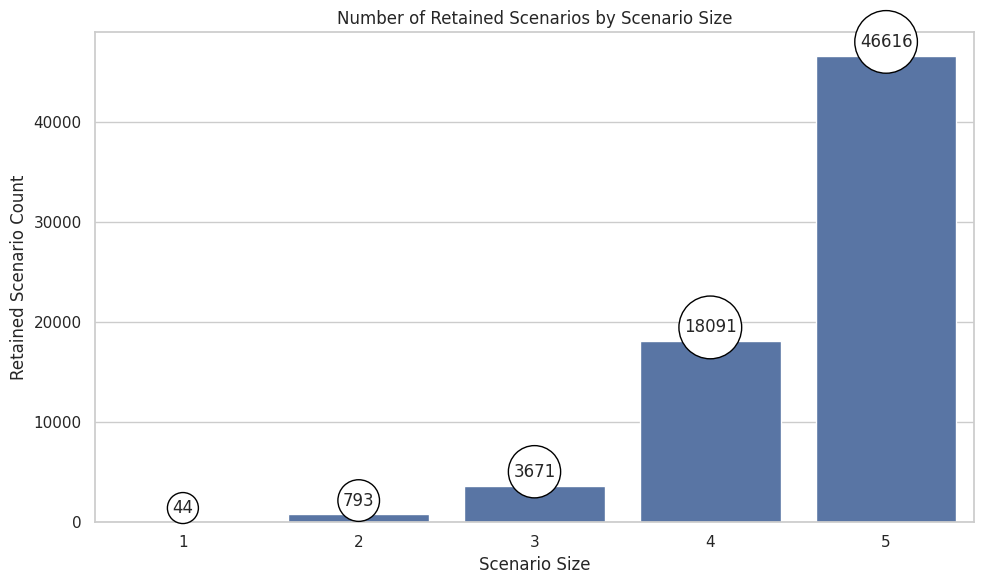

In [ ]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 6))

# Compute counts per scenario size
counts = df_all_retained['scenario_size'].value_counts().sort_index()

ax = sns.barplot(x=counts.index.astype(str), y=counts.values)
ax.set_title('Number of Retained Scenarios by Scenario Size')
ax.set_xlabel('Scenario Size')
ax.set_ylabel('Retained Scenario Count')

# Annotate each bar with its count inside a circle
top = counts.max() * 1.02
for i, (size, count) in enumerate(counts.items()):
    ax.text(i, count + (top * 0.01), str(count), ha='center', va='bottom', fontsize=12,
            bbox=dict(boxstyle='circle,pad=0.3', fc='white', ec='black'))

plt.tight_layout()
plt.show()

## Section 9: Scenario → Recipe Matching

Bu hücre, `final_generated_scenarios_map` içindeki her bir senaryoyu, önceden oluşturduğumuz `index_map` ve `recipe_df_with_id` üzerinden çok hızlı set‑intersection metodu ile eşleştirir; eşleşen tariflerin ID ve Name’lerini toplar.


In [ ]:
# ---------------------------------------------------------------------------
# Section 9-10: Full Recipe Matching & Ground Truth Export
# ---------------------------------------------------------------------------

import os
import logging
import ast
import json
import pandas as pd

# --- Logger Setup ----------------------------------------------------------
log = logging.getLogger()

# --- Internal ID Column ---------------------------------------------------
internal_id_col = 'recipe_id'

# --- 1. Prepare recipe_df_with_id -----------------------------------------
if 'RecipeId' in df_raw.columns:
    recipe_df_with_id = df_raw.drop_duplicates('RecipeId').copy()
    recipe_df_with_id.rename(columns={'RecipeId': internal_id_col}, inplace=True)
else:
    recipe_df_with_id = df_raw.reset_index().rename(columns={'index': internal_id_col})
recipe_df_with_id[internal_id_col] = recipe_df_with_id[internal_id_col].astype(str)
if 'Name' not in recipe_df_with_id.columns:
    recipe_df_with_id['Name'] = 'Name Unavailable'
log.info(f"Prepared recipe_df_with_id with {len(recipe_df_with_id)} entries.")

# --- 2. Collect Generated Scenarios ---------------------------------------
scenarios_map = {}
for size in FULL_SIZES:
    path = os.path.join(OUTPUT_DIR, f"full_scenarios_size_{size}.csv")
    df_s = pd.read_csv(path)
    df_s['scenario_list'] = df_s['scenario'].apply(ast.literal_eval)
    scenarios_map[size] = df_s['scenario_list'].tolist()
    log.info(f"Loaded {len(scenarios_map[size])} full scenarios of size {size} from {path}.")
for size in SAMPLE_SIZES:
    path = os.path.join(OUTPUT_DIR, f"sampled_scenarios_size_{size}.csv")
    df_s = pd.read_csv(path)
    df_s['scenario_list'] = df_s['scenario'].apply(ast.literal_eval)
    scenarios_map[size] = df_s['scenario_list'].tolist()
    log.info(f"Loaded {len(scenarios_map[size])} sampled scenarios of size {size} from {path}.")

# --- 3. Perform Matching --------------------------------------------------
matches = []
global_idx = 0
total = sum(len(v) for v in scenarios_map.values())
log.info(f"Starting matching for {total} scenarios.")

for size, scen_list in sorted(scenarios_map.items()):
    for local_idx, scen in enumerate(scen_list):
        idx_sets = [index_map[(rel, val)] for rel, val in scen]
        matched_idxs = set.intersection(*sorted(idx_sets, key=len)) if idx_sets else set()
        count = len(matched_idxs)

        idx_list = list(matched_idxs)
        if count:
            hits = recipe_df_with_id.loc[idx_list, [internal_id_col, 'Name']]
            ids = hits[internal_id_col].tolist()
            names = hits['Name'].tolist()
        else:
            ids, names = [], []

        matches.append({
            'scenario_global_id':     global_idx,
            'scenario_size':          size,
            'scenario_index_in_size': local_idx,
            'scenario_criteria':      json.dumps(scen, ensure_ascii=False),
            'matching_recipe_count':  count,
            'matching_recipe_ids':    ",".join(map(str, ids)),
            'matching_recipe_names':  " ||| ".join(names),
        })

        global_idx += 1
        if global_idx % 1000 == 0:
            log.info(f"Processed {global_idx}/{total} scenarios...")

log.info(f"Matching completed: processed {global_idx} scenarios.")

# --- 4. Create DataFrame & Export -----------------------------------------
matches_df = pd.DataFrame(matches)

# Export separate ground truth files for sizes 1,2,3,4,5
for size in [1,2,3,4,5]:
    sub_df = matches_df[matches_df['scenario_size'] == size]
    out_csv = os.path.join(OUTPUT_DIR, f"ground_truth_{size}.csv")
    sub_df.to_csv(out_csv, index=False, encoding='utf-8')
    log.info(f"Saved {len(sub_df)} rows to {out_csv}")

print("✅ Recipe matching and ground-truth CSV export complete.")


INFO:root:Prepared recipe_df_with_id with 88519 entries.
INFO:root:Loaded 44 full scenarios of size 1 from /content/scenario_detailed_v3/full_scenarios_size_1.csv.
INFO:root:Loaded 793 full scenarios of size 2 from /content/scenario_detailed_v3/full_scenarios_size_2.csv.
INFO:root:Loaded 3671 sampled scenarios of size 3 from /content/scenario_detailed_v3/sampled_scenarios_size_3.csv.
INFO:root:Loaded 18091 sampled scenarios of size 4 from /content/scenario_detailed_v3/sampled_scenarios_size_4.csv.
INFO:root:Loaded 46616 sampled scenarios of size 5 from /content/scenario_detailed_v3/sampled_scenarios_size_5.csv.
INFO:root:Starting matching for 69215 scenarios.
INFO:root:Processed 1000/69215 scenarios...
INFO:root:Processed 2000/69215 scenarios...
INFO:root:Processed 3000/69215 scenarios...
INFO:root:Processed 4000/69215 scenarios...
INFO:root:Processed 5000/69215 scenarios...
INFO:root:Processed 6000/69215 scenarios...
INFO:root:Processed 7000/69215 scenarios...
INFO:root:Processed 8000

✅ Recipe matching and ground-truth CSV export complete.
